In [1]:
import os
import pygad
import random 
import seaborn as sns

cwd = os.getcwd()
pygad_loc = '/grid/home/nbourgeois/codonOpt'
os.chdir(pygad_loc)
from general_functions import *
from metrics import *
from codon_tools import *
import RNA
import numpy as np
os.chdir(cwd)

Using TensorFlow backend.


In [2]:
def gen_random_seqs(prot_seq, num_seqs):
    codon_usage_table_loc = os.path.join(pygad_loc,'references','codon_usage.getex.txt')
    codon_to_int, codon_space = init_parameters(prot_seq, codon_usage_table_loc) 
    
    positions = len(codon_space)
    size_vector = [len(codon_pos) for codon_pos in codon_space] 
    seqs = [None]*num_seqs
    for i in range(num_seqs):
        rand_index = [random.randrange(size) for size in size_vector]
        seqs[i] = ''.join(([space[ind] for ind, space in zip(rand_index,codon_space)]))
    return(seqs)

def calculate_MFE(seq, window):
    values=[]
    for i in range(len(seq)):
        temp_seq=seq[i:i+window]
        (ss, mfe) = RNA.fold(temp_seq)
        values.append(mfe)
    return(values)

def get_mfe(seq_aa):
    all_mfe = calculate_MFE(seq_aa,10)
    mfe = np.mean(all_mfe)  * -1
    return(mfe)

def readFasta( fastaFile: str ):
    fastaId = ''
    fastaSeq = ''
    if os.path.exists( fastaFile ):
        try:
            with open( fastaFile, "r") as handle:
                cont = 0
                fastaIds = []
                fastaSeqs = []
                for record in SeqIO.parse( handle, "fasta"):
                    fastaIds.append(record.id)
                    fastaSeqs.append(record.seq)
        except IOError as e:
            print( "I/O error({0}): {1}".format(e.errno, e.strerror) )
        except:
            print( "Unexpected error:", sys.exc_info()[0] )
    else:
        print("File does not exist:" + fastaFile )
        sys.exit(2)
    return (fastaIds, fastaSeqs)

def calculate_MFE(seq, window):
    values=[]
    for i in range(len(seq)):
        temp_seq=seq[i:i+window]
        (ss, mfe) = RNA.fold(temp_seq)
        values.append(mfe)
    return(values)

def calculate_delta(arr):
    delta = np.array(arr[1:]) - np.array(arr[:-1]) 
    return(delta)

def smoothen(values):
    num_avg = 200
    inc = int(np.floor(num_avg/2))
    stop = len(values) - inc
    smoothed = [np.mean(values[i-inc:i+inc+1]) for i in range(inc,stop)]
    return(smoothed)

def plot_MFE(values,val):
    sns.set_context('talk')
    fig,(ax,ax2)=plt.subplots(2,1,figsize=(24,8))
    smoothed = smoothen(values)
#     delta = calculate_delta(smoothed)

    ax.plot(np.arange(len(values)),values,label='{}nt Regions'.format(val))
    ax2.plot(np.arange(len(smoothed)),smoothed,label='Smoothed {}nt Regions'.format(val))
#     ax3.plot(np.arange(len(delta)),delta,label='Delta {}nt Regions'.format(val))

#     ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',frameon=False)
    sns.despine(offset=10)
    ax.set_xlabel('Position (nt)')
#     ax.set_xlim(0,len(seq))

    ax.set_ylabel('Minimum Free Energy')
    ax.set_title('DNA Secondary Structure Prediction in {}nt Rolling Intervals'.format(val),size=24,pad=20)
    
def predictSites_multi( fastaIds,fastaSeqs,threshold=.1):

    gpu0_avail = gpu_memory_usage(0)
    gpu1_avail = gpu_memory_usage(1)
    if gpu0_avail + gpu1_avail > 30000:
        print('Out of memory\n')
        return(-1)
    if gpu0_avail < gpu1_avail:
        gpu="0"
    else:
        gpu="1"
    
    os.environ["CUDA_VISIBLE_DEVICES"]=gpu

    from keras.models import load_model
    import tensorflow as tf
    from tensorflow import keras

    results = {}
    gpus =tf.config.experimental.list_physical_devices('GPU')

    try: 
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
        
        context = 10000
        keras.backend.set_learning_phase(0)
        paths = ('models/spliceai{}.h5'.format(x) for x in range(1, 6))
        models = [load_model(resource_filename('spliceai', x), compile=False ) for x in paths]
        for seq_id, seq in zip(fastaIds,fastaSeqs):

            x = one_hot_encode('N'*(context//2) + str(seq) + 'N'*(context//2))[None, :]
            y = np.mean([models[m].predict(x) for m in range(5)], axis=0)
            acceptor_prob = y[0, :, 1]
            donor_prob = y[0, :, 2]
            coord = list( range(1, len( donor_prob ) ) )
                    
            # custom metric
            results[seq_id] = (len(acceptor_prob[acceptor_prob > threshold]) + len(donor_prob[donor_prob > .1]))/2
        return(results)
    except tf.errors as e:
        # Splice AI custome sequeence prediction
        print(e,'\n')
        return(-1)

# Read Proteins


In [3]:
# PAH 
loc = '/grid/home/nbourgeois/data/test_proteins/pah/pah.pep.fas' #sequence pep.fas Input

(keys, seqs) = readFasta(loc)
if len(seqs) == 1:
    pah_seq=str(seqs[0])
    
# PAH targets
loc = '/grid/home/nbourgeois/data/test_proteins/pah/MMUT.pep.fas' #sequence pep.fas Input
(keys, seqs) = readFasta(loc)
if len(seqs) == 1:
    pahtar_seq1=str(seqs[0])
    
loc = '/grid/home/nbourgeois/data/test_proteins/pah/OTC.pep.fas' #sequence pep.fas Input
(keys, seqs) = readFasta(loc)
if len(seqs) == 1:
    pahtar_seq2=str(seqs[0])
    
loc = '/grid/home/nbourgeois/data/test_proteins/pah/ATP7B.pep.fas' #sequence pep.fas Input
(keys, seqs) = readFasta(loc)
if len(seqs) == 1:
    pahtar_seq3=str(seqs[0])
    

#hidua
loc = '/grid/home/nbourgeois/data/test_proteins/hidua/hidua.pep.fas' #sequence pep.fas Input
(keys, seqs) = readFasta(loc)
if len(seqs) == 1:
    hidua_seq=str(seqs[0])
    
prefixes = ['pah','MMUT','OTC','ATP7B','hidua']
proteins = [pah_seq,pahtar_seq1,pahtar_seq2,pahtar_seq3,hidua_seq]
tissues = ['Liver','Liver','Liver','Liver','Brain_Cerebellum']

In [ ]:
ids = []
cpgs = []
bais = []
cais = []
spss = []
seqs = []
mfes = []
all_prefixes = []
n_seq = 10000

for prefix, aa_seq, tissue in zip(prefixes, proteins, tissues):
    
    subids = [prefix + '_' + str(i) for i in range(n_seq)]
    cai_weight_dict = get_codon_weights(tissue)
    bai_weight_dict = get_bicodon_weights(tissue)
    rand_seqs = gen_random_seqs(aa_seq,n_seq)

    for seq in rand_seqs:
        bais.append(get_bai(seq,bai_weight_dict))
        cais.append(get_cai(seq,cai_weight_dict))
        cpgs.append(get_cpg(seq))
        mfes.append(get_mfe(seq))
        

    seqs.extend(rand_seqs)
    ids.extend(subids)
    res = predictSites_multi(subids,rand_seqs)
    spss.extend([res[an_id] for an_id in subids])
    all_prefixes.extend([prefix]*n_seq)

df = pd.DataFrame(data={'ID':ids,'Protein':all_prefixes,'Seq':seqs,'CAI':cais,'BAI':bais,'CPG':cpgs,'SPS':spss,'MFE':mfes})

In [21]:
df = df.sample(frac=1)


# CAI v BAI

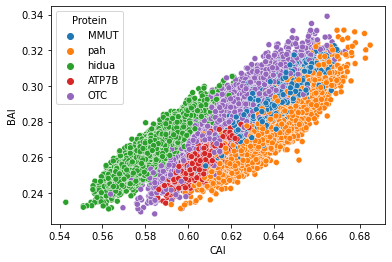

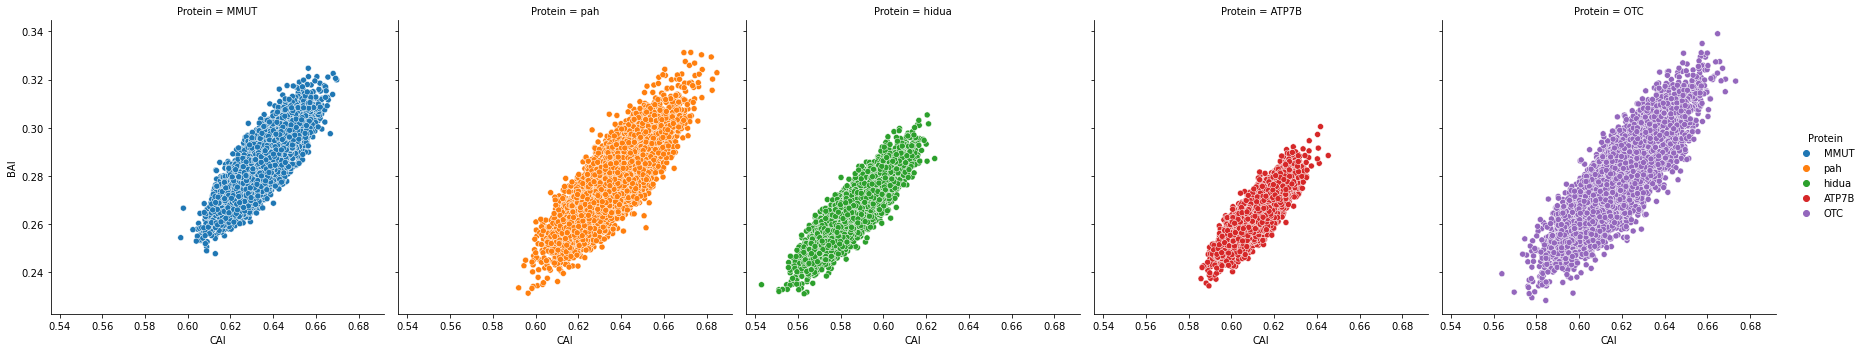

In [30]:
x= 'CAI'
y='BAI'
sns.scatterplot(data=df, x=x, y=y, hue="Protein")
sns.relplot(data=df, x=x, y=y,  hue="Protein", col='Protein')

# BAI v SS

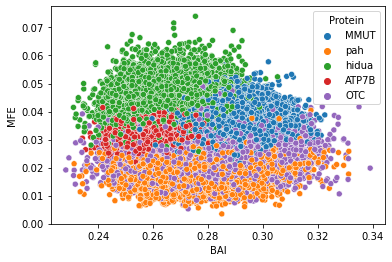

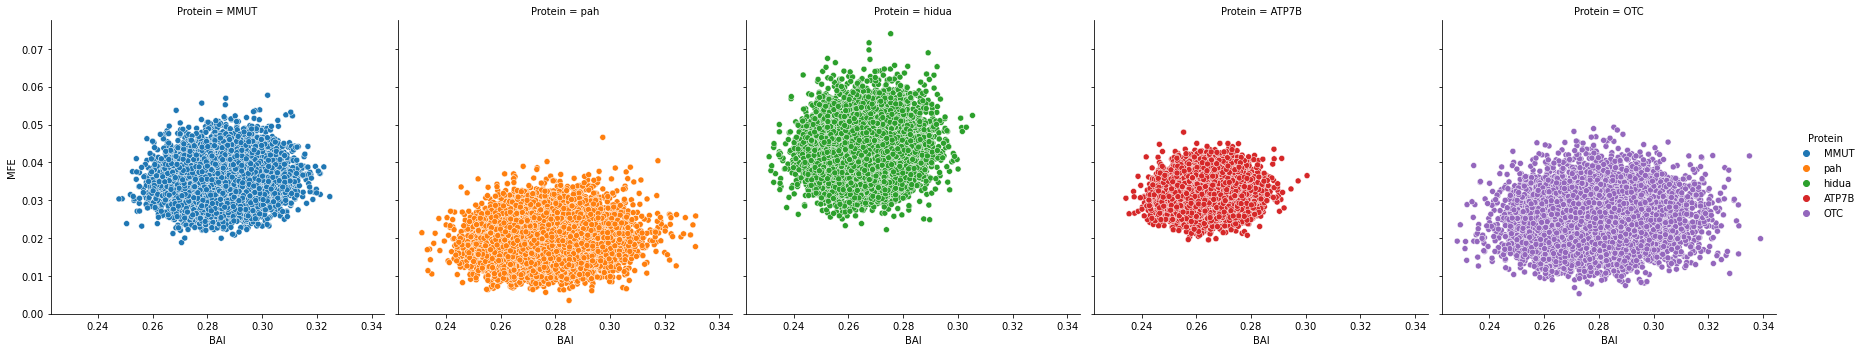

In [31]:
x= 'BAI'
y='MFE'
sns.scatterplot(data=df, x=x, y=y, hue="Protein")
sns.relplot(data=df, x=x, y=y,  hue="Protein", col='Protein')

# BAI v SPS

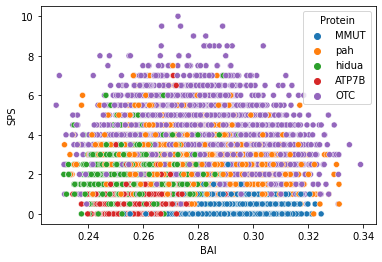

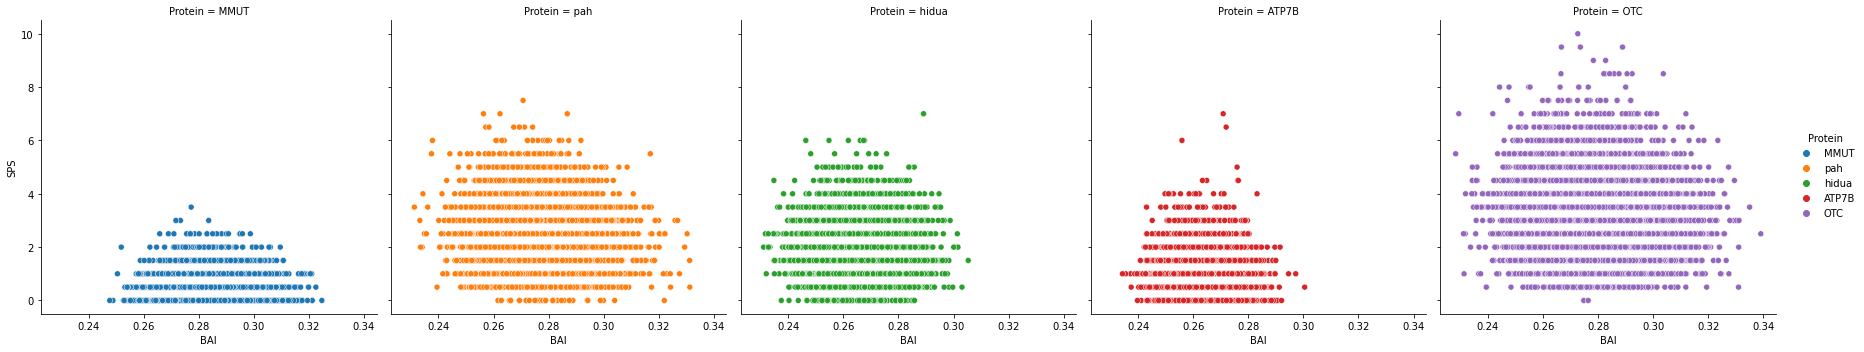

In [32]:
x= 'BAI'
y='SPS'
sns.scatterplot(data=df, x=x, y=y, hue="Protein")
sns.relplot(data=df, x=x, y=y,  hue="Protein", col='Protein')

# BAI v CPG

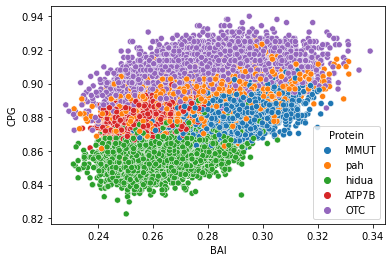

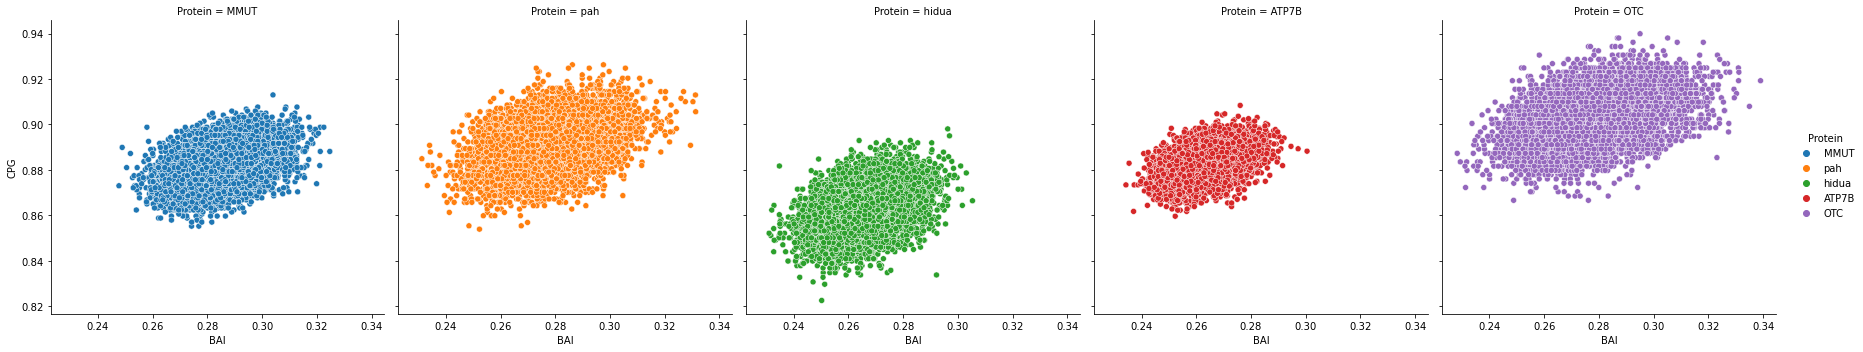

In [33]:
x= 'BAI'
y='CPG'
sns.scatterplot(data=df, x=x, y=y, hue="Protein")
sns.relplot(data=df, x=x, y=y,  hue="Protein", col='Protein')

# CPG v SPS

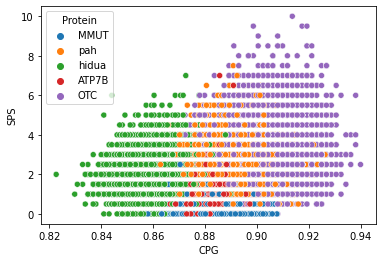

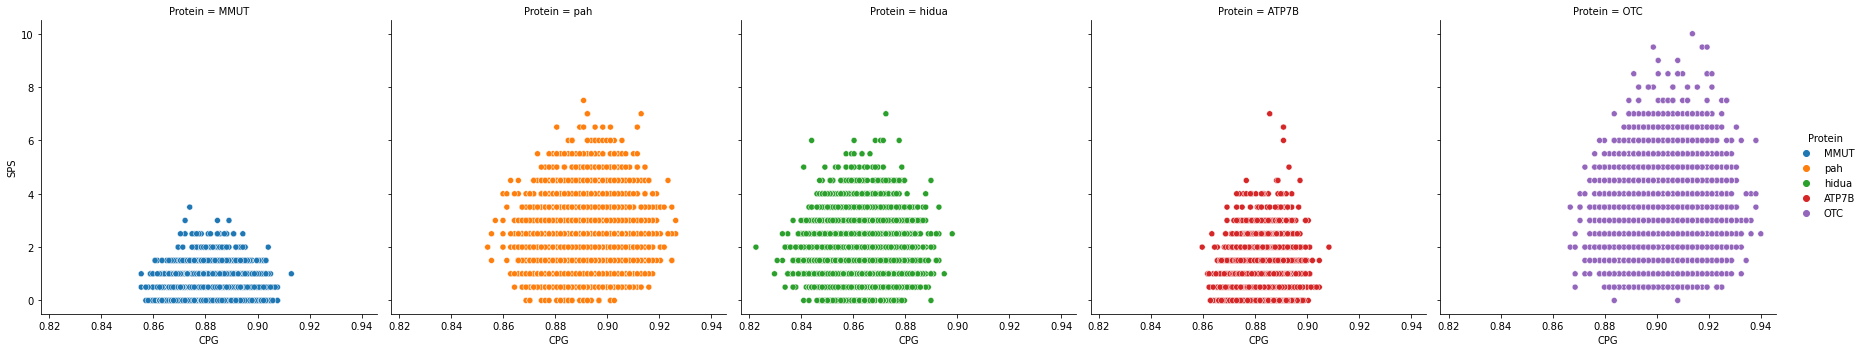

In [34]:
x= 'CPG'
y='SPS'
sns.scatterplot(data=df, x=x, y=y, hue="Protein")
sns.relplot(data=df, x=x, y=y,  hue="Protein", col='Protein')

# CPG v SS

ERROR! Session/line number was not unique in database. History logging moved to new session 1583


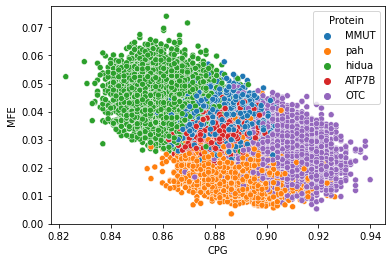

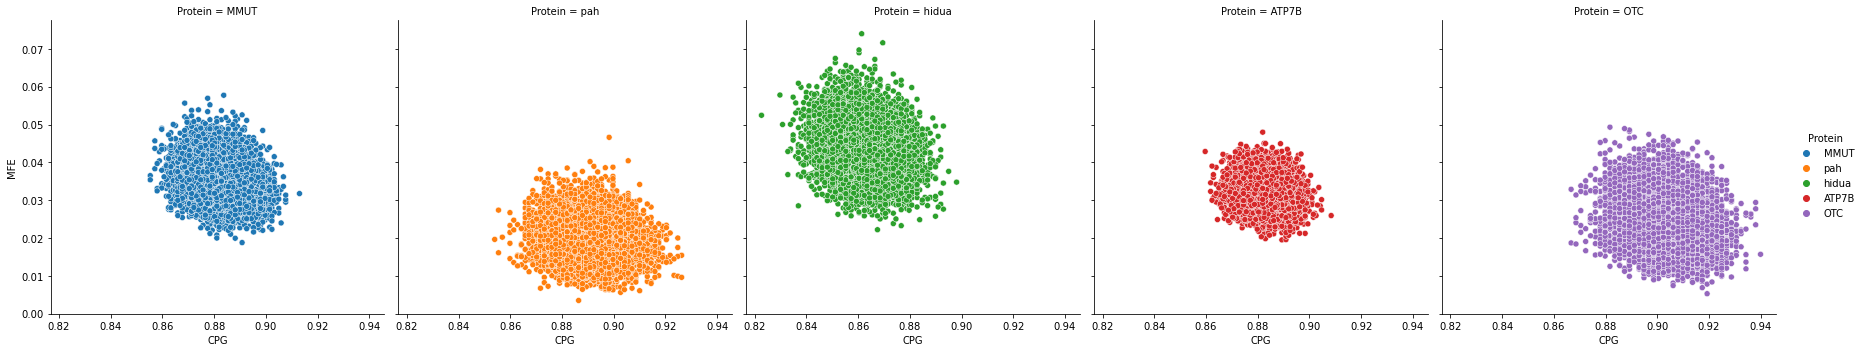

In [35]:
x= 'CPG'
y='MFE'
sns.scatterplot(data=df, x=x, y=y, hue="Protein")
sns.relplot(data=df, x=x, y=y,  hue="Protein", col='Protein')

# SPS v SS

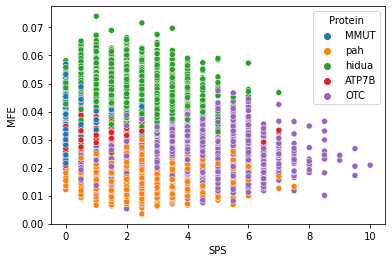

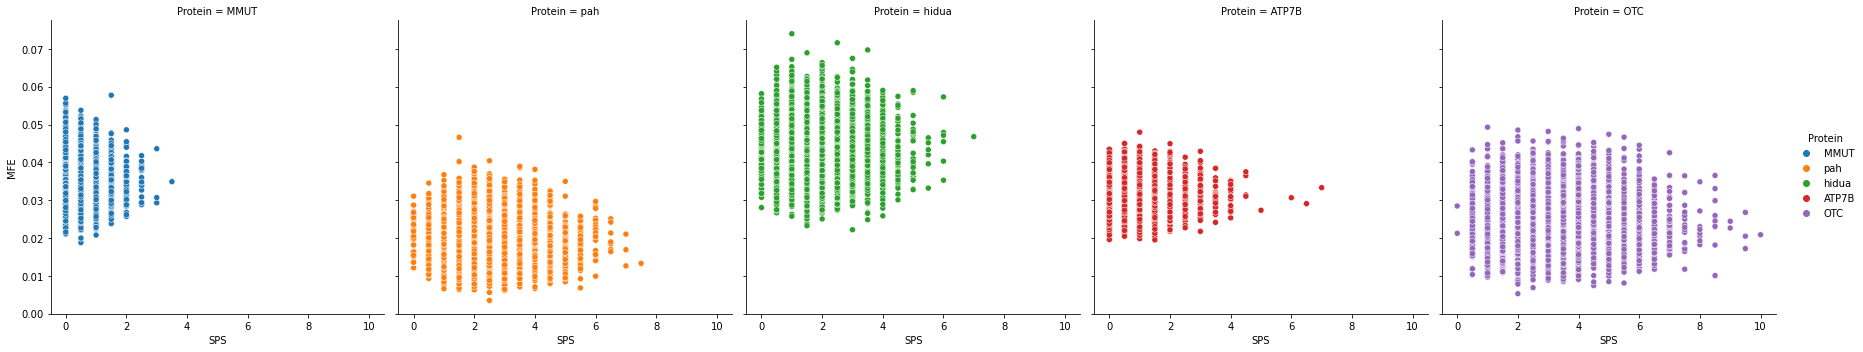

In [36]:
x= 'SPS'
y='MFE'
sns.scatterplot(data=df, x=x, y=y, hue="Protein")
sns.relplot(data=df, x=x, y=y,  hue="Protein", col='Protein')